# Training Classifier Humerus

In [1]:
!pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 4.1MB/s 


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
import cv2

import seaborn as sns
from PIL import Image

from tqdm import tqdm_notebook,tqdm


from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras.layers import  Convolution2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalMaxPooling1D
from keras.layers import AveragePooling2D
from keras.models import  Sequential
import imutils
from keras.applications.resnet import ResNet50,ResNet152,preprocess_input,decode_predictions
from keras.applications.densenet import DenseNet121,DenseNet169,preprocess_input,decode_predictions
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import efficientnet.keras as efn 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Generating MetaDataframes

In [4]:
def returnDf(bodypart,path):

  train_imgs_path=pd.read_csv(path+'MURA-v1.1/train_image_paths.csv',names=['img_path'])
  test_imgs_path=pd.read_csv(path+'MURA-v1.1/valid_image_paths.csv',names=['img_path'])


  train_imgs_path['Body_Part']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  train_imgs_path['Study_No']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  train_imgs_path['label']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[7:])

  test_imgs_path['Body_Part']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  test_imgs_path['Study_No']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  test_imgs_path['label']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[7:])


  train_df=train_imgs_path[train_imgs_path['Body_Part']==bodypart]
  test_df=test_imgs_path[test_imgs_path['Body_Part']==bodypart]

  train_df['img_path']=[path + i for i in train_df['img_path']]
  test_df['img_path']=[path + i for i in test_df['img_path']]
  
  #train_labels['Body_Part']=train_labels['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  #train_labels['Study_Type']=train_labels['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  #test_labels['Body_Part']=test_labels['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  #test_labels['Study_Type']=test_labels['img_path'].apply(lambda x: str(x.split('/')[4])[:6])


  #train_labels['img_path']=train_imgs_path.iloc[:,0]
  #test_labels['img_path']=test_imgs_path.iloc[:,0]
    
  #train_df=train_labels[train_labels['Body_Part']==bodypart]
  #test_df=test_labels[test_labels['Body_Part']==bodypart]
  #train_df['img_path']=[path + i for i in train_df['img_path']]
  #train_df['label']=train_df['label'].astype('str')
  #test_df['img_path']=[path + i for i in test_df['img_path']]
  #test_df['label']=test_df['label'].astype('str')
  train_df['label']=[str(1) if i=='positive' else str(0) for i in train_df['label']]
  test_df['label']=[str(1) if i=='positive' else str(0) for i in test_df['label']]

  return train_df, test_df

In [5]:
train_df,test_df=returnDf('HUMERUS','gdrive/My Drive/Capstone Medical Imaging/Data.nosync/')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [6]:
train_df.head()

,img_path,Body_Part,Study_No,label
8379,gdrive/My Drive/Capstone Medical Imaging/Data....,HUMERUS,study1,1
8380,gdrive/My Drive/Capstone Medical Imaging/Data....,HUMERUS,study1,1
8381,gdrive/My Drive/Capstone Medical Imaging/Data....,HUMERUS,study1,1
8382,gdrive/My Drive/Capstone Medical Imaging/Data....,HUMERUS,study1,1
8383,gdrive/My Drive/Capstone Medical Imaging/Data....,HUMERUS,study1,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272 entries, 8379 to 9650
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   1272 non-null   object
 1   Body_Part  1272 non-null   object
 2   Study_No   1272 non-null   object
 3   label      1272 non-null   object
dtypes: object(4)
memory usage: 49.7+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 1420 to 1707
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   288 non-null    object
 1   Body_Part  288 non-null    object
 2   Study_No   288 non-null    object
 3   label      288 non-null    object
dtypes: object(4)
memory usage: 11.2+ KB


In [9]:
 train_df['img_path'].iloc[1]

'gdrive/My Drive/Capstone Medical Imaging/Data.nosync/MURA-v1.1/train/XR_HUMERUS/patient02626/study1_positive/image1.png'

In [10]:
train_df['label'].value_counts()

0    673
1    599
Name: label, dtype: int64

In [11]:
test_df['label'].value_counts()

0    148
1    140
Name: label, dtype: int64

Baseline accuracy on training is 59%

In [12]:
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

In [13]:
train_df.head().iterrows()

<generator object DataFrame.iterrows at 0x7fc5dac4d6d0>

5it [00:07,  1.54s/it]


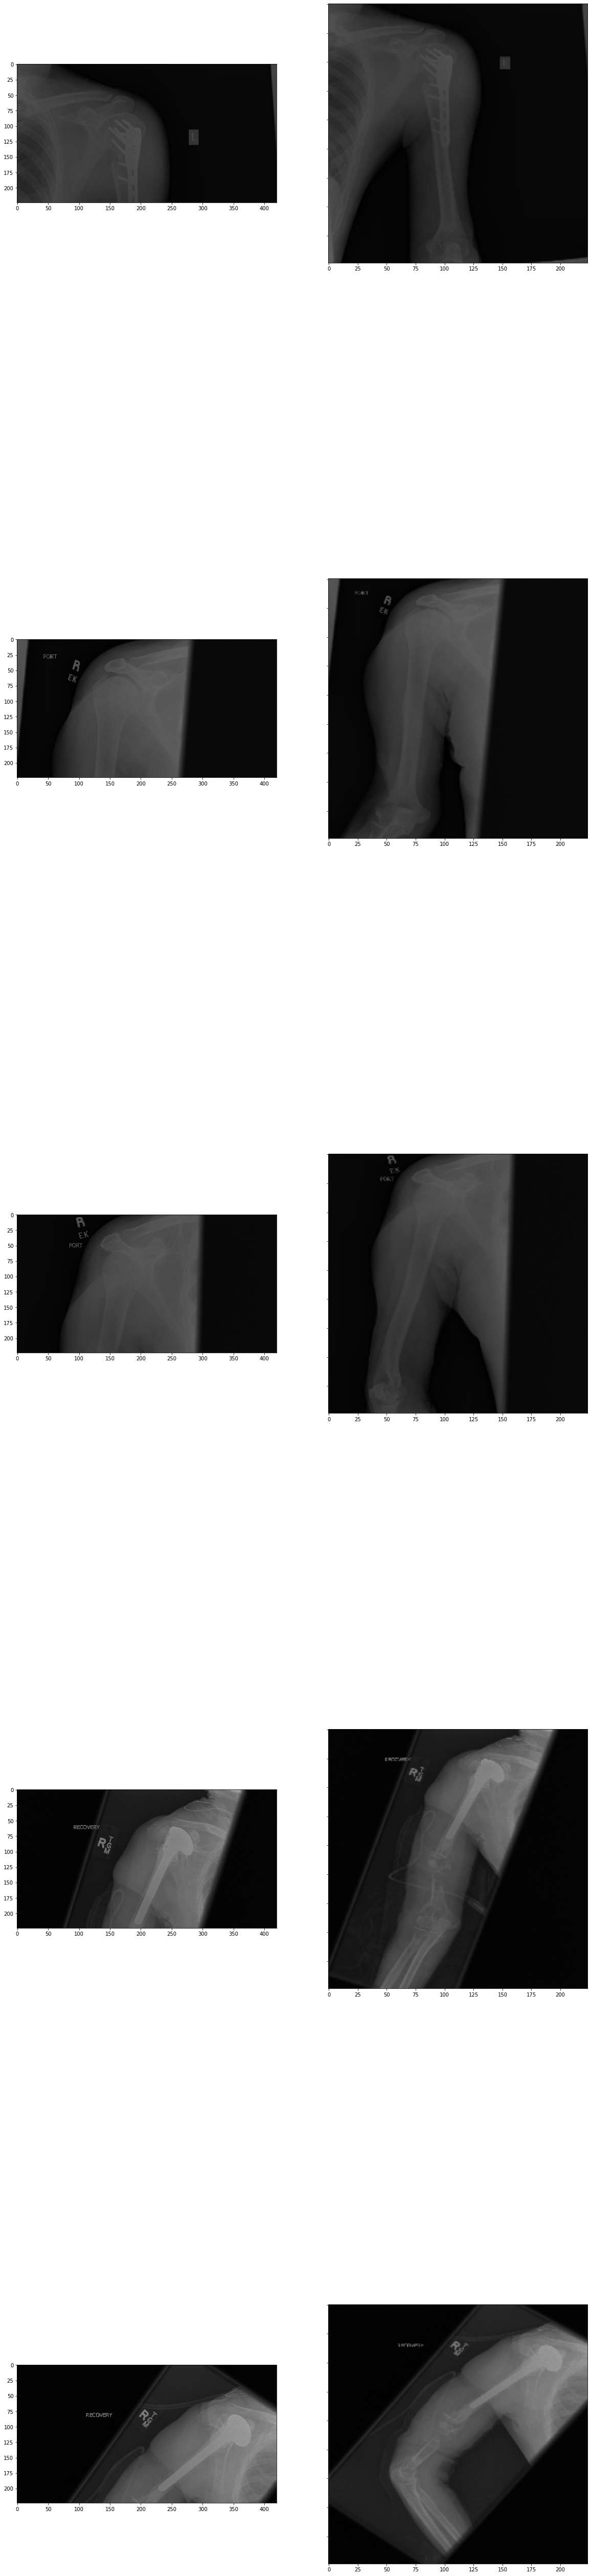

In [14]:
fig,ax=plt.subplots(5,2,sharey=True,figsize=(20,100))
image_dict={}
image_dict['images']=[]
image_dict['label']=[]
count=0
for index,row in tqdm(train_df.head().iterrows()):
  img_arr=cv2.imread(row['img_path'])
  ax[count,0].imshow(img_arr)
  
  resized_arr=cv2.resize(img_arr,(224,224))
  
  ax[count,1].imshow(resized_arr)
  count+=1
                     
  

#image_dict['images']=(image_dict['images']-mean_imagenet)/std_imagenet

# Creating image generators with simple preprocessing and options for data augmentation

In [15]:
def returnImgGen(train_df,test_df,IMG_SIZE=(224,224),rotation_range=0,horizontal_flip=False):
  datagen=ImageDataGenerator(
    horizontal_flip=horizontal_flip,
    #vertical_flip=True,
    rotation_range=rotation_range,
    #fill_mode='nearest',
    #preprocessing_function=preprocess_input)
    rescale=1./255.)



  train_gen=datagen.flow_from_dataframe(train_df,
                           x_col='img_path',
                           y_col='label',
                           target_size=IMG_SIZE,
                           color_mode='rgb',
                           class_mode='binary',batch_size=8,seed=101)

  
    
  val_gen=datagen.flow_from_dataframe(test_df,
                           x_col='img_path',
                           y_col='label',
                           target_size=IMG_SIZE,
                           color_mode='rgb',
                           class_mode='binary', batch_size=1,seed=101)
    
    
  return train_gen, val_gen



In [16]:
train_gen_224,val_gen_224=returnImgGen(train_df,test_df)

Found 1272 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.


In [17]:
def plot_val_train_loss(hist):
  loss_train = hist.history['loss']
  loss_val = hist.history['val_loss']
  epochs = range(1,len(hist.history['val_loss'])+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Augmented Data Image Generators

In [18]:
train_gen_aug,val_gen_aug=returnImgGen(train_df,test_df,IMG_SIZE=(224,224),rotation_range=30,horizontal_flip=True)

Found 1272 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.


# DenseNet169 with Augmentation

In [19]:
weight_path="{}_weights.best.hdf5".format('best_densenet_humerus_classifier')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model17=Sequential()
model17.add(DenseNet169(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model17.add(Flatten())
model17.add(Dense(1, activation='sigmoid'))
model17.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model17.summary()

history17=model17.fit(train_gen_aug,validation_data=val_gen_aug,epochs=30,callbacks=callbacks_list_3,shuffle=True)

51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 12,486,145
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.5354 - mse: 0.2614
Epoch 00001: val_loss improved from inf to 363.98450, saving model to best_densenet_humerus_classifier_weights.best.hdf5
159/159 [==============================] - 706s 4s/step - loss: 0.7449 -

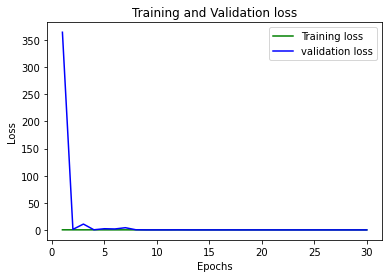

In [20]:
plot_val_train_loss(history17)

In [21]:
from google.colab import files
files.download("best_densenet_humerus_classifier_weights.best.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
model17.load_weights('best_densenet_humerus_classifier_weights.best.hdf5')

In [23]:
Y_pred = model17.predict(val_gen_aug)


In [24]:
predictions = []
for p in Y_pred:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
print('Confusion Matrix')
print(confusion_matrix(val_gen_aug.classes, predictions))
print('Classification Report')
target_names = ['Normal','Abnormal']
print(classification_report(val_gen_aug.classes, predictions, target_names=target_names))

Confusion Matrix
[[87 61]
 [87 53]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.50      0.59      0.54       148
    Abnormal       0.46      0.38      0.42       140

    accuracy                           0.49       288
   macro avg       0.48      0.48      0.48       288
weighted avg       0.48      0.49      0.48       288



In [27]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_gen_aug.classes, predictions)

In [28]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

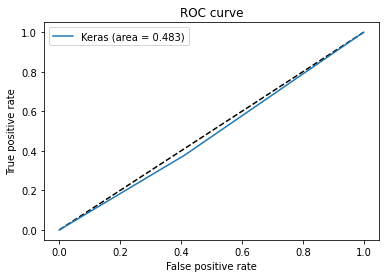

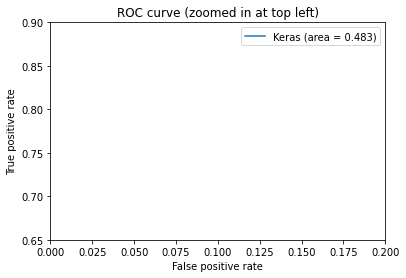

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.2)
plt.ylim(0.65, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# EfficientNet with Augmentation

In [30]:
weight_path="{}_weights.best.hdf5".format('best_efficientnet0_humerus_classifier')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model19=Sequential()
model19.add(efn.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model19.add(Flatten())
model19.add(Dense(1, activation='sigmoid'))
model19.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model19.summary()

history19=model19.fit(train_gen_aug,validation_data=val_gen_aug,epochs=30,callbacks=callbacks_list_3,shuffle=True)

16809984/16804768 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 1280)              4049564   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________
Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 0.6267 - accuracy: 0.6808 - mse: 0.2086
Epoch 00001: val_loss improved from inf to 0.57683, saving model to best_efficientnet0_humerus_classifier_weights.best.hdf5
159/159 [==============================] - 26s 164ms/step - loss: 0.62

In [31]:
from google.colab import files
files.download("best_efficientnet0_humerus_classifier_weights.best.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>